<a href="https://colab.research.google.com/github/PozzOver13/learning/blob/main/bayesian_modeling/20250305_bayesian_hierachical_models_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Hierarchical Models

## Definizione

I modelli gerarchici bayesiani (Bayesian Hierarchical Models, BHM) sono una classe di modelli statistici che combinano la modellazione gerarchica con l'approccio bayesiano per catturare la struttura multi-livello dei dati e incorporare informazioni a priori.

## Caratteristiche principali
**Struttura Gerarchica**  
* I parametri del modello sono organizzati in più livelli, riflettendo la struttura naturale dei dati (es. individui all'interno di gruppi).
* Le osservazioni condividono parametri comuni, ma ogni sottogruppo può avere caratteristiche specifiche.  

**Approccio Bayesiano**  
* Si utilizza la Regola di Bayes per aggiornare le credenze sui parametri alla luce dei dati osservati.
* Si definiscono distribuzioni a priori per i parametri, che vengono aggiornate in distribuzioni a posteriori.

**Pooling dell'Informazione**

* Complete Pooling: si assume che tutti i gruppi condividano lo stesso parametro (sovrastima la similarità).
* No Pooling: ogni gruppo ha un parametro indipendente (sottostima la similarità).
* Partial Pooling (Shrinking): i parametri di gruppo sono parzialmente vincolati da un livello superiore, ottenendo un compromesso tra complete e no pooling.

## Vantaggi e Svantaggi  
✅ Stime più robuste quando i dati per alcuni gruppi sono scarsi.  
✅ Permette di incorporare conoscenza preesistente tramite distribuzioni a priori.  
✅ Modella naturalmente la variabilità tra gruppi.  

❌ Computazionalmente intensivo (richiede metodi MCMC o VI).  
❌ Sensibile alla scelta della distribuzione a priori.

## References

https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import xarray as xr
import arviz as az

In [2]:


# Impostiamo il seed per replicabilità
np.random.seed(42)

# Definizione delle regioni
regioni = ["Regione 1", "Regione 2"]

# Definizione delle classi energetiche ordinate
classi_energetiche = ["A", "B", "C", "D", "E", "F", "G"]

# Numero di perizie simulate per regione
n_perizie = 500

# Media globale dei prezzi
mu_globale = 1500  # €/mq

# Definiamo effetti specifici per classe energetica (espressi in €/mq rispetto alla media)
effetti_classe = {
    "A": 200,  # Prezzo più alto
    "B": 150,
    "C": 100,
    "D": 50,
    "E": -50,
    "F": -100,
    "G": -200  # Prezzo più basso
}

# Generiamo un dataset con le perizie
dati = []
for regione in regioni:
    # Definiamo una media regionale con una piccola variazione
    mu_regione = mu_globale + np.random.normal(0, 200)  # Media regionale con variazione casuale

    for _ in range(n_perizie):
        classe = np.random.choice(classi_energetiche, p=[0.1, 0.15, 0.2, 0.2, 0.15, 0.1, 0.1])  # Distribuzione casuale

        # Prezzo determinato da media globale, variazione regionale e classe energetica
        prezzo_mq = mu_regione + effetti_classe[classe] + np.random.normal(0, 50)  # Rumore
        dati.append([regione, classe, prezzo_mq])

# Creiamo il DataFrame
df = pd.DataFrame(dati, columns=["Regione", "ClasseEnergetica", "Prezzo_mq"])

# Controlliamo i primi dati generati
df.head()


,Regione,ClasseEnergetica,Prezzo_mq
0,Regione 1,E,1542.429616
1,Regione 1,D,1637.635162
2,Regione 1,A,1787.635983
3,Regione 1,F,1578.303471
4,Regione 1,A,1837.714567


In [3]:
# Statistiche descrittive
df.groupby(["Regione"])["Prezzo_mq"].median()

,Prezzo_mq
Regione,
Regione 1,1654.850765
Regione 2,1472.145890


In [4]:
# Statistiche descrittive
df.groupby(["Regione", "ClasseEnergetica"])["Prezzo_mq"].median()

Regione    ClasseEnergetica
Regione 1  A                   1796.607283
           B                   1747.705167
           C                   1700.393023
           D                   1648.417174
           E                   1558.665546
           F                   1510.294640
           G                   1394.673481
Regione 2  A                   1613.261972
           B                   1571.013444
           C                   1520.959090
           D                   1478.350916
           E                   1367.628243
           F                   1342.740568
           G                   1223.975271
Name: Prezzo_mq, dtype: float64

In [5]:
# Statistiche descrittive
df.groupby(["Regione", "ClasseEnergetica"])["Prezzo_mq"].describe()

count         mean        std          min  \
Regione   ClasseEnergetica                                               
Regione 1 A                  56.0  1796.063246  46.950074  1637.279464   
          B                  77.0  1744.627386  44.607319  1614.498498   
          C                  89.0  1701.806369  52.011032  1595.246360   
          D                 103.0  1647.074476  45.666484  1548.085701   
          E                  65.0  1560.463761  50.472718  1457.299119   
          F                  54.0  1504.296667  48.337847  1397.436604   
          G                  56.0  1399.101590  49.374086  1288.786065   
Regione 2 A                  46.0  1616.730066  43.774149  1528.199685   
          B                  67.0  1567.816880  50.115731  1446.173756   
          C                  92.0  1522.861762  47.932415  1378.046128   
          D                 100.0  1475.174332  50.374650  1360.004902   
          E                  85.0  1366.340273  59.719563  1198.419247   
          F                  61.0  1334.896703  41.873568  1208.610128   
          G                  49.0  1219.316293  39.502874  1144.369345   

                                    25%          50%          75%          max  
Regione   ClasseEnergetica                                                      
Regione 1 A                 1763.875833  1796.607283  1814.962060  1922.504936  
          B                 1717.473474  1747.705167  1776.470833  1842.631556  
          C                 1666.211643  1700.393023  1739.969122  1803.962194  
          D                 1616.713697  1648.417174  1680.555763  1729.002162  
          E                 1522.817773  1558.665546  1593.424818  1741.979405  
          F                 1471.179868  1510.294640  1538.368485  1612.877473  
          G                 1373.360754  1394.673481  1424.102141  1528.010821  
Regione 2 A                 1585.879030  1613.261972  1644.573761  1713.058694  
          B                 1536.436918  1571.013444  1589.991003  1705.618806  
          C                 1487.287267  1520.959090  1552.533606  1656.836406  
          D                 1437.481350  1478.350916  1510.737342  1583.594469  
          E                 1332.335051  1367.628243  1400.957203  1520.710206  
          F                 1312.712428  1342.740568  1358.640217  1413.438340  
          G                 1188.415324  1223.975271  1243.186779  1292.330423

In [50]:
df["log_prezzo_mq"] = log_prezzo_mq = np.log(df.Prezzo_mq + 0.1).values
df = df.sort_values(["Regione", "ClasseEnergetica"], ascending=[True, False])
df.ClasseEnergetica = df.ClasseEnergetica.map(str.strip)

ape, mn_ape = df.ClasseEnergetica.factorize()
df["ape_num"] = ape
ape_mean = df.groupby("ape_num").log_prezzo_mq.mean()

regione_num, mn_regione = df.ClasseEnergetica.factorize()
df["regione_num"] = regione_num


In [51]:
ape_mean

,log_prezzo_mq
ape_num,
0,7.178911
1,7.252280
2,7.276773
3,7.352044
4,7.382562
5,7.414232
6,7.445626


In [7]:
mn_ape.to_list()

['G', 'F', 'E', 'D', 'C', 'B', 'A']

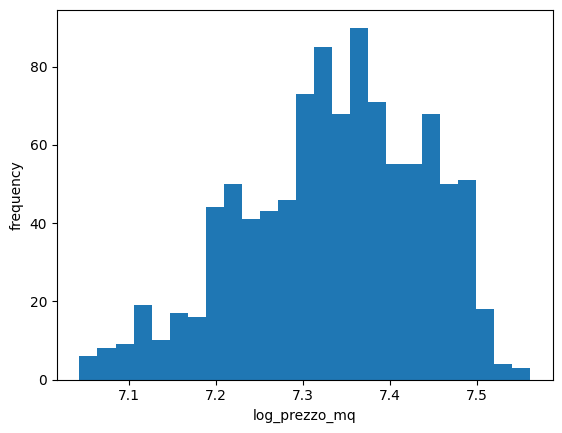

In [8]:
df.log_prezzo_mq.hist(bins=25, grid=False)
plt.xlabel("log_prezzo_mq")
plt.ylabel("frequency");

## Complete Pooling

In [62]:
ape_mean_np

array([7.17891108, 7.25228011, 7.27677271, 7.35204373, 7.38256195,
       7.41423163, 7.44562638])

In [65]:
with pm.Model() as pooled_model:
  ape_mean_ = pm.MutableData("ape_mean", ape_mean, dims="obs_id")  # Use ape_idx to index into ape_mean
  alpha = pm.Normal("alpha", 0, sigma=10)
  beta = pm.Normal("beta", mu=0, sigma=10)
  sigma = pm.Exponential("sigma", 5)

  theta = alpha + beta * ape_mean_  # Index into ape_mean using ape_idx

  y = pm.Normal("y", theta, sigma=sigma, observed=log_prezzo_mq, dims="obs_id")

/usr/local/lib/python3.11/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


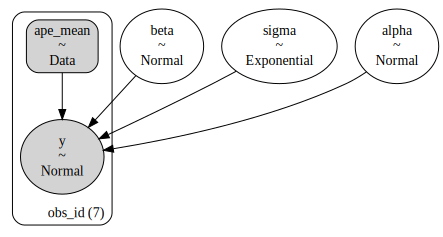

In [66]:
pm.model_to_graphviz(pooled_model)

In [67]:
RANDOM_SEED = 13
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

In [68]:
mn_ape.to_list()

['G', 'F', 'E', 'D', 'C', 'B', 'A']

In [73]:
ape_mean.to_xarray()

<xarray.DataArray 'log_prezzo_mq' (ape_num: 7)> Size: 56B
array([7.17891108, 7.25228011, 7.27677271, 7.35204373, 7.38256195,
       7.41423163, 7.44562638])
Coordinates:
  * ape_num  (ape_num) int64 56B 0 1 2 3 4 5 6

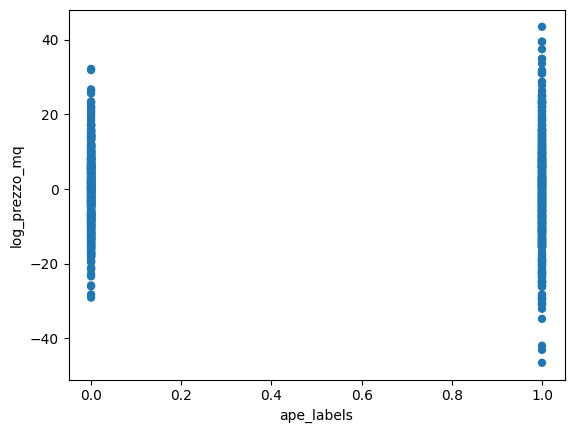

In [57]:
prior = prior_checks.prior.squeeze(drop=True)
(
    xr.concat((prior["alpha"], prior["alpha"] + prior["beta"]), dim="ape_labels")
    .rename("log_prezzo_mq")
    #.assign_coords(ape_labels=mn_ape.to_list())
    .plot.scatter(x="ape_labels", y="log_prezzo_mq", edgecolors="none")
)

In [58]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=RANDOM_SEED)

ValueError: Input dimension mismatch: (input[%i].shape[%i] = %lld, input[%i].shape[%i] = %lld)
Apply node that caused the error: Composite{(i3 - (i2 + (i0 * i1)))}(ExpandDims{axis=0}.0, ape_ind, ExpandDims{axis=0}.0, y{[7.2269135 ... .37154786]})
Toposort index: 6
Inputs types: [TensorType(float64, shape=(1,)), TensorType(float64, shape=(None,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(1000,))]
Inputs shapes: [(1,), (7,), (1,), (1000,)]
Inputs strides: [(8,), (8,), (8,), (8,)]
Inputs values: [array([-0.6376179]), 'not shown', array([0.33463209]), 'not shown']
Outputs clients: [[Sum{axes=None}(Composite{(i3 - (i2 + (i0 * i1)))}.0), Composite{...}(Composite{(i3 - (i2 + (i0 * i1)))}.0, ExpandDims{axis=0}.0, ape_ind, Log.0, Gt.0)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [59]:
az.summary(pooled_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,7.33,0.01,7.31,7.34,0.0,0.0,793.78,1119.90,1.0
beta,0.00,0.00,-0.00,0.01,0.0,0.0,795.93,871.80,1.0
sigma,0.10,0.00,0.10,0.11,0.0,0.0,1292.22,1075.16,1.0


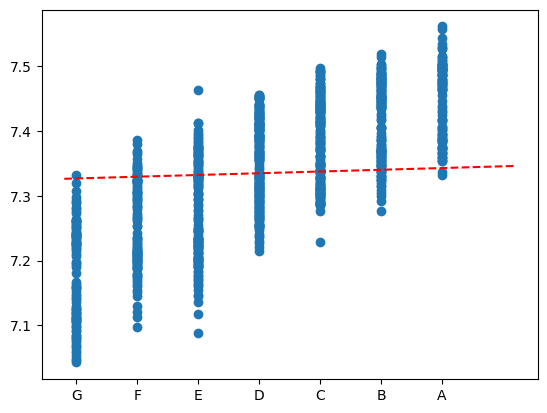

In [17]:
post_mean = pooled_trace.posterior.mean(dim=("chain", "draw"))

plt.scatter(df.ClasseEnergetica, np.log(df.Prezzo_mq + 0.1))
xvals = xr.DataArray(np.linspace(-0.2, 7.2))
plt.plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--");

## Unpooled

In [18]:
coords = {"ape": mn_ape}

with pm.Model(coords=coords) as unpooled_model:
    ape_ind = pm.MutableData("ape_ind", ape, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10, dims="ape")
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[ape] + beta * ape_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_prezzo_mq, dims="obs_id")

/usr/local/lib/python3.11/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


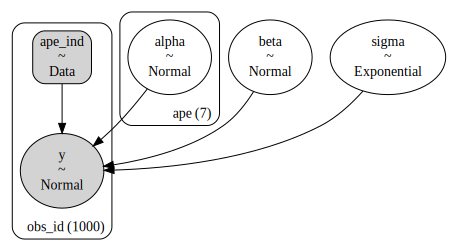

In [19]:
pm.model_to_graphviz(unpooled_model)

In [20]:
with unpooled_model:
    unpooled_trace = pm.sample(random_seed=RANDOM_SEED)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [21]:
az.summary(unpooled_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[G],7.33,0.01,7.31,7.35,0.00,0.00,223.73,367.89,1.01
alpha[F],5.62,0.96,3.42,7.16,0.21,0.15,22.51,40.50,1.10
alpha[E],3.87,1.91,-0.51,6.94,0.42,0.30,22.51,40.50,1.10
alpha[D],2.16,2.87,-4.42,6.76,0.63,0.45,22.51,40.50,1.10
alpha[C],0.44,3.82,-8.35,6.55,0.83,0.60,22.51,40.50,1.10
alpha[B],-1.29,4.78,-12.25,6.36,1.04,0.75,22.51,40.50,1.10
alpha[A],-3.00,5.73,-16.16,6.20,1.25,0.90,22.52,40.50,1.10
beta,1.72,0.96,0.20,3.92,0.21,0.16,22.52,40.50,1.10
sigma,0.10,0.00,0.10,0.11,0.00,0.00,340.01,559.86,1.01


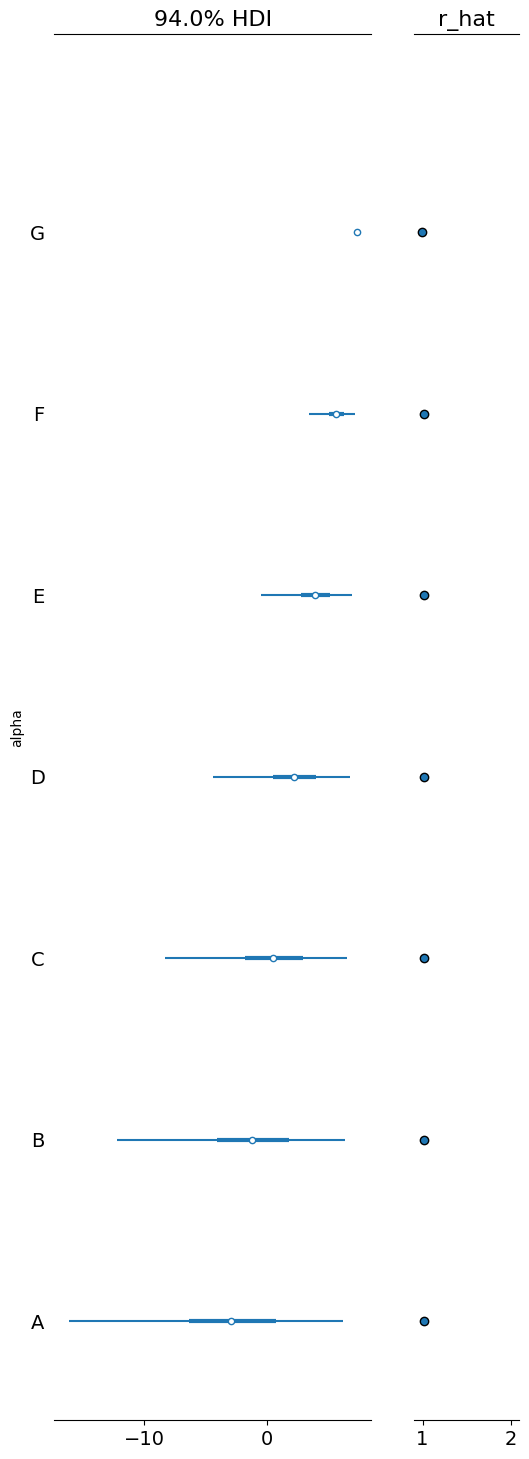

In [22]:
ax = az.plot_forest(
    unpooled_trace,
    var_names=["alpha"],
    r_hat=True,
    combined=True,
    figsize=(6, 18),
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha");

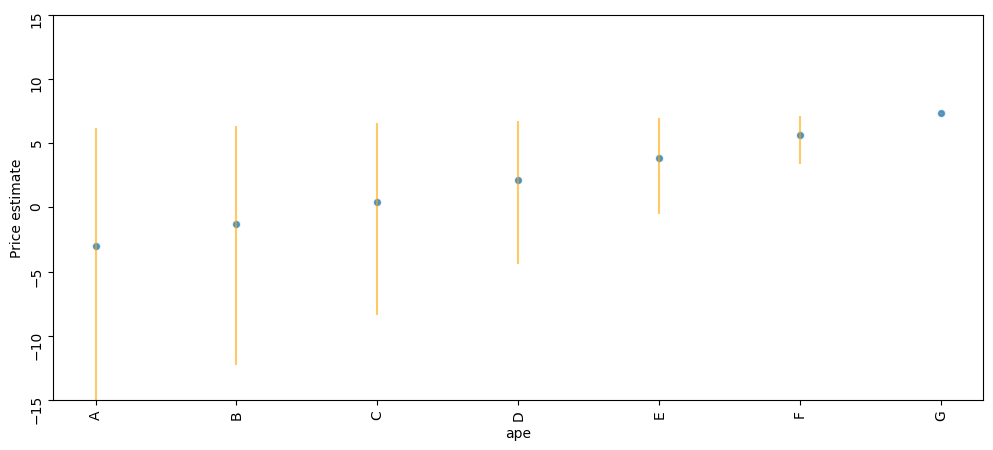

In [23]:
unpooled_means = unpooled_trace.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_trace)

unpooled_means_iter = unpooled_means.sortby("alpha")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.alpha)

_, ax = plt.subplots(figsize=(12, 5))
xticks = np.arange(0, 7, 1)
unpooled_means_iter.plot.scatter(x="ape", y="alpha", ax=ax, alpha=0.8)
ax.vlines(
   np.arange(mn_ape.size),
   unpooled_hdi_iter.alpha.sel(hdi="lower"),
   unpooled_hdi_iter.alpha.sel(hdi="higher"),
   color="orange",
   alpha=0.6,
)
ax.set(ylabel="Price estimate", ylim=(-15, 15))
ax.set_xticks(xticks)
ax.set_xticklabels(unpooled_means_iter.ape.values[xticks])
ax.tick_params(rotation=90);

# Multilevel and hierarchical models

## Partial Pooling model

In [25]:
with pm.Model(coords=coords) as partial_pooling:
    ape_idx = pm.MutableData("ape_idx", ape, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=7.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="ape")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 1)

    # Expected value
    y_hat = alpha[ape_idx]

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_prezzo_mq, dims="obs_id")

/usr/local/lib/python3.11/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


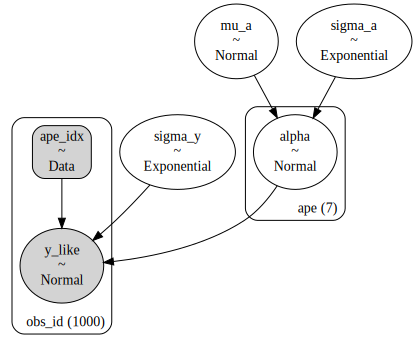

In [26]:
pm.model_to_graphviz(partial_pooling)

In [27]:
with partial_pooling:
    partial_pooling_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Output()

ERROR:pymc.stats.convergence:There were 58 divergences after tuning. Increase `target_accept` or reparameterize.


In [43]:
az.summary(unpooled_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[G],7.33,0.01,7.31,7.35,0.00,0.00,223.73,367.89,1.01
alpha[F],5.62,0.96,3.42,7.16,0.21,0.15,22.51,40.50,1.10
alpha[E],3.87,1.91,-0.51,6.94,0.42,0.30,22.51,40.50,1.10
alpha[D],2.16,2.87,-4.42,6.76,0.63,0.45,22.51,40.50,1.10
alpha[C],0.44,3.82,-8.35,6.55,0.83,0.60,22.51,40.50,1.10
alpha[B],-1.29,4.78,-12.25,6.36,1.04,0.75,22.51,40.50,1.10
alpha[A],-3.00,5.73,-16.16,6.20,1.25,0.90,22.52,40.50,1.10
beta,1.72,0.96,0.20,3.92,0.21,0.16,22.52,40.50,1.10
sigma,0.10,0.00,0.10,0.11,0.00,0.00,340.01,559.86,1.01


In [41]:
az.summary(partial_pooling_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[G],7.33,0.01,7.32,7.35,0.0,0.0,1251.51,887.12,1.00
alpha[F],7.34,0.01,7.33,7.35,0.0,0.0,1236.71,963.15,1.00
alpha[E],7.33,0.01,7.31,7.34,0.0,0.0,526.96,1062.32,1.00
alpha[D],7.34,0.01,7.33,7.35,0.0,0.0,1369.98,1301.87,1.00
alpha[C],7.34,0.01,7.32,7.35,0.0,0.0,1399.36,1268.09,1.00
alpha[B],7.34,0.01,7.33,7.35,0.0,0.0,1076.52,1265.37,1.00
alpha[A],7.34,0.01,7.33,7.36,0.0,0.0,701.32,1157.44,1.00
mu_a,7.34,0.01,7.33,7.35,0.0,0.0,1272.37,1166.73,1.00
sigma_a,0.01,0.01,0.00,0.02,0.0,0.0,224.11,139.94,1.01
sigma_y,0.10,0.00,0.10,0.11,0.0,0.0,1212.80,1200.18,1.01


In [46]:
az.hdi(unpooled_trace).alpha.sel(hdi="lower").values

array([  7.31195164,   3.41798935,  -0.51104635,  -4.4205162 ,
        -8.35474515, -12.25265725, -16.16126274])

In [47]:
az.hdi(partial_pooling_trace).alpha.sel(hdi="lower").values

array([7.31884416, 7.32502613, 7.31172401, 7.32515886, 7.32458292,
       7.32533428, 7.32773913])

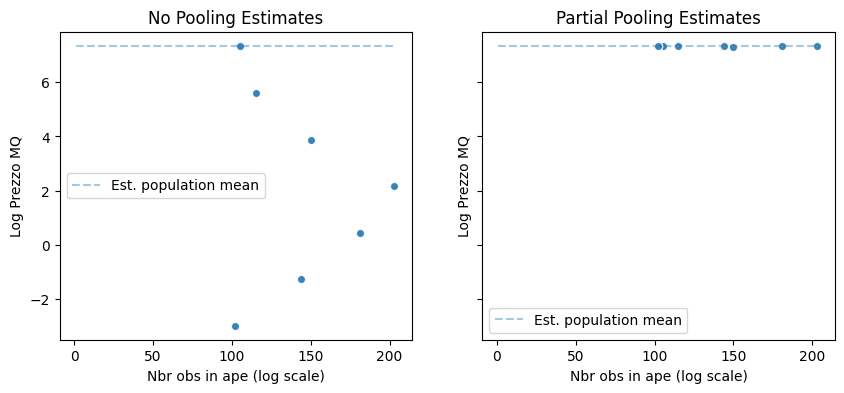

In [44]:
N_ape = df.groupby("ape_num").size().values

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, trace, level in zip(
    axes,
    (unpooled_trace, partial_pooling_trace),
    ("no pooling", "partial pooling"),
):
    # add variable with x values to xarray dataset
    trace.posterior = trace.posterior.assign_coords({"N_ape": ("ape", N_ape)})
    # plot means
    trace.posterior.mean(dim=("chain", "draw")).plot.scatter(
        x="N_ape", y="alpha", ax=ax, alpha=0.9
    )
    ax.hlines(
        partial_pooling_trace.posterior.alpha.mean(),
        0.9,
        max(N_ape) + 1,
        alpha=0.4,
        ls="--",
        label="Est. population mean",
    )

    # plot hdi
    hdi = az.hdi(trace).alpha
    if level == "partial pooling":
        ax.vlines(N_ape, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="orange", alpha=0.5)

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Nbr obs in ape (log scale)",
        #xscale="log",
        ylabel="Log Prezzo MQ",
    )
    ax.legend(fontsize=10)